In [2]:
from __future__ import annotations
from jinja2 import Template
from jinja2.environment import Environment
import tempered
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from random import randint
from typing_extensions import Callable, LiteralString
from pathlib import Path
import numpy as np
import warnings

warnings.simplefilter("ignore", DeprecationWarning)
output_dir = Path("./output")
output_dir.mkdir(exist_ok=True)


def benchmark_renders(samples: int, render_func: Callable[[], str]) -> list[float]:
    BATCH_SIZE = max(min(samples, samples // 1000), 1)

    def benchmark_batch() -> float:
        render_start = time.perf_counter()
        for _ in range(BATCH_SIZE):
            render_func()
        render_end = time.perf_counter()
        return (render_end - render_start) / BATCH_SIZE

    return [benchmark_batch() for _ in range(samples // BATCH_SIZE)]


def benchmark_jinja(
    template: str,
    count: int,
    variables: dict | None = None,
) -> list[float]:
    jinja2_template = Template(template, autoescape=True)
    variables = variables or {"x": randint(0, 100_000)}
    render_func = lambda: jinja2_template.render(**variables)
    render_times = benchmark_renders(count, render_func)
    return render_times


def benchmark_tempered(
    template: LiteralString,
    other_templates: list[tuple[str, LiteralString]],
    count: int,
    variables: dict | None = None,
) -> list[float]:
    templates = tempered.Tempered()
    templates.add_templates_from_string({
        "benchmark": template,
        **dict(other_templates)
    })
    variables = variables or {"x": randint(0, 100_000)}
    func = lambda: templates.render_template("benchmark", **variables)

    render_times = benchmark_renders(count, func)
    return render_times


summary = ""


def benchmark_comparion(
    name: str,
    samples: int,
    jinja2_template: str,
    tempered_template: LiteralString,
    additional_tempered_templates: list[tuple[str, LiteralString]] = [],
    variables: dict | None = None,
):
    global total, summary
    jinja_render_times = benchmark_jinja(jinja2_template, samples, variables)
    jinja_avg_render = np.mean(jinja_render_times)

    tempered_render_times = benchmark_tempered(
        tempered_template, additional_tempered_templates, samples, variables
    )
    tempered_avg_render = np.mean(tempered_render_times)

    print(f"{'Jinja2 Renders/s:':<20} {1 / tempered_avg_render:,.0f}s")
    print(f"{'Tempered Renders/s:':<20} {1 / tempered_avg_render:,.0f}")
    improvement_ratio =jinja_avg_render / tempered_avg_render
    print(f"{'Rendering Faster:':<20} {improvement_ratio * 100:.2f}%")

    temepred_rates = [int(1 / x) for x in tempered_render_times]
    jinja_rates = [int(1 / x) for x in jinja_render_times]

    summary += f"{name:>20}: {jinja_avg_render * 1000}ms\n"
    # plt.rcParams["axes.formatter.limits"] = (-99, 99)
    fig, ax = plt.subplots()
    benchmark_name = name.replace("_", "" "").title()
    plt.title(f"{benchmark_name} Benchmark")
    plt.boxplot(
        x=[
            temepred_rates,
            jinja_rates,
        ],
        labels=["Tempered", "Jinja2"],
    )
    min = np.percentile(temepred_rates + jinja_rates, [0.01])
    max = np.percentile(temepred_rates + jinja_rates, [99.99])
    plt.ylim(min - (min / 3), max + (max / 3))

    plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter("%d/s"))
    yticks = ax.get_yticks()
    for ytick in yticks:
        plt.hlines(ytick, 0, 3, colors="black", linestyles="dotted", alpha=0.1)
    plt.savefig(output_dir / f"benchmark_{name}.png")
    plt.show()


def finalise():
    with open(output_dir / "results.txt", "w") as f:
        f.write(summary)

## Variables

Jinja2 Renders/s:    100,601s
Tempered Renders/s:  100,601
Rendering Faster:    222.58%


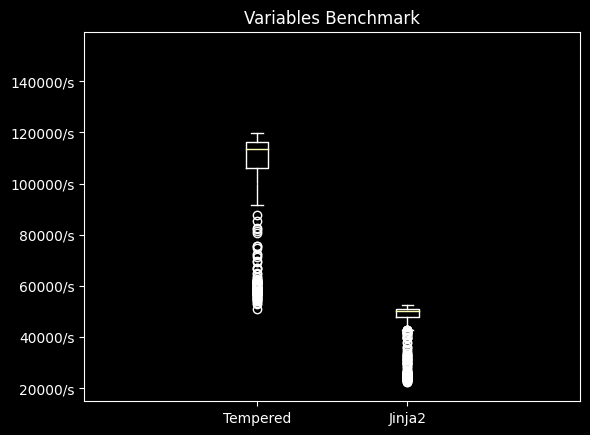

In [3]:
jinja_template = (
    """
{% if x % 2 == 0 %}
    {{ x }} is even
{% else %}
    {{ x }} is odd
{% endif %}
"""
    * 10
)
benchmark_comparion(
    name="variables",
    samples=100_000,
    jinja2_template=jinja_template,
    tempered_template=jinja_template,
)
from tempered._internals import escape

## For Loops

Jinja2 Renders/s:    539,338s
Tempered Renders/s:  539,338
Rendering Faster:    854.53%


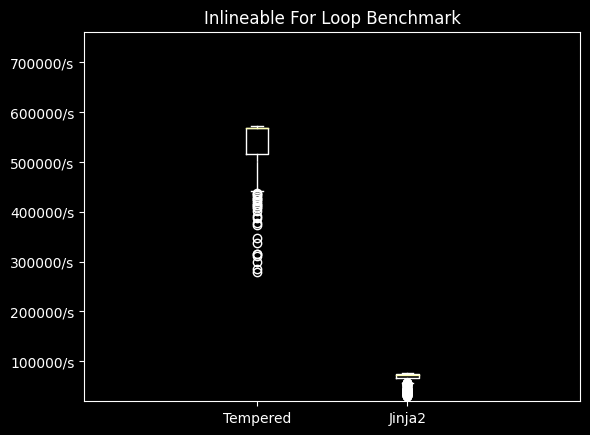

In [4]:
jinja_template = """
{% for x in range(10) %}
    Foo
{% endfor %}
"""
benchmark_comparion(
    name="Inlineable For Loop",
    samples=100_000,
    jinja2_template=jinja_template,
    tempered_template=jinja_template,
)

Jinja2 Renders/s:    283,634s
Tempered Renders/s:  283,634
Rendering Faster:    505.69%


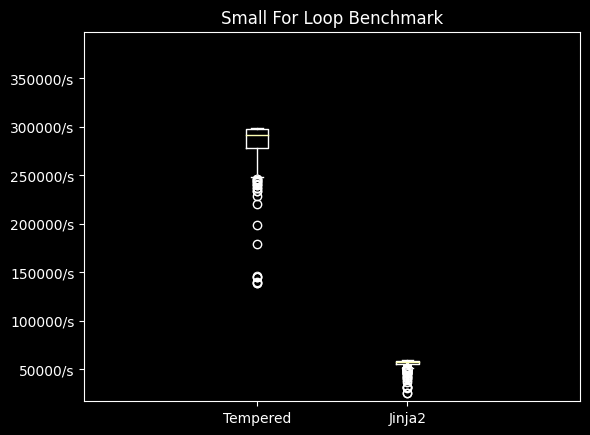

In [5]:
jinja_template = """
{% for x in range(5) %}
    {{ x }}
{% endfor %}
"""
benchmark_comparion(
    name="Small for loop",
    samples=100_000,
    jinja2_template=jinja_template,
    tempered_template=jinja_template,
)


Jinja2 Renders/s:    1,957s
Tempered Renders/s:  1,957
Rendering Faster:    156.10%


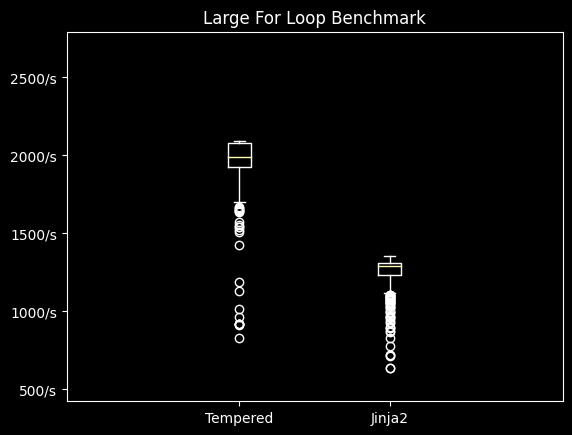

KeyboardInterrupt: 

In [ ]:
jinja_template = """
{% for x in range(1000) %}
    {{ x }}
{% endfor %}
"""
benchmark_comparion(
    name="Large for loop",
    samples=1000,
    jinja2_template=jinja_template,
    tempered_template=jinja_template,
)


Jinja2 Renders/s:    38s
Tempered Renders/s:  38
Rendering Faster:    161.46%


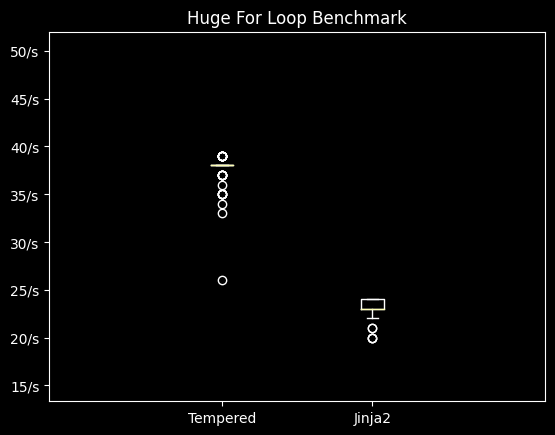

In [ ]:
jinja_template = """
{% for x in range(50_000) %}
    {{ x }}
{% endfor %}
"""
benchmark_comparion(
    name="Huge for loop",
    samples=100,
    jinja2_template=jinja_template,
    tempered_template=jinja_template,
)


Jinja2 Renders/s:    113,701s
Tempered Renders/s:  113,701
Rendering Faster:    6926.57%


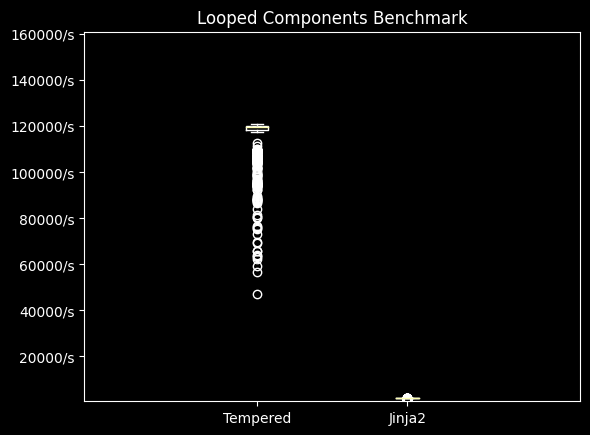

In [ ]:
benchmark_comparion(
    name="Looped Components",
    samples=10_000,
    jinja2_template="""
    {% macro img(x) -%}
        <img src="https://picsum.photos/200/300?random={{ x }}" />
    {% endmacro -%}

    {% for x in range(100) %}
        {{ img(x) }}
    {% endfor %}
    """,
    tempered_template="""
    {% for x in range(100) %}
        {<img()>}
    {% endfor %}
    """,
    additional_tempered_templates=[
        ("img", '<img src="https://picsum.photos/200/300?random={{ x }}" />'),
    ],
)


## Components

Jinja2 Renders/s:    701,858s
Tempered Renders/s:  701,858
Rendering Faster:    2520.36%


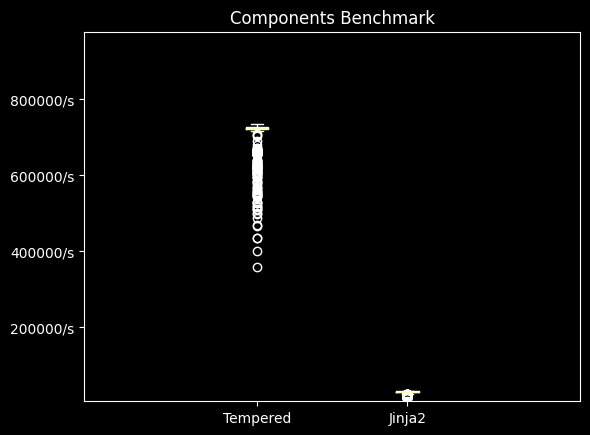

In [ ]:
benchmark_comparion(
    name="components",
    samples=50_000,
    jinja2_template="""
    {% macro m_a(x) -%}
        {{ m_b(x) }}
    {% endmacro -%}
    {% macro m_b(x) -%}
        {{ m_c(x) }}
    {% endmacro -%}
    {% macro m_c(x) -%}
        {{ x}}
    {% endmacro -%}

    {{ m_a(x) }}
    """,
    tempered_template="""
        {%param x: int%}
        {<m_a(x=x)>}
        {{ x }}
    """,
    additional_tempered_templates=[
        (
            "m_a",
            """
            {%param x: int%}
            {<m_b(x=x)>}
        """,
        ),
        (
            "m_b",
            """
            {%param x: int%}
            {<m_c(x=x)>}
        """,
        ),
        (
            "m_c",
            """
            {%param x: int%}
            {{ x }}
        """,
        ),
    ],
)


## Small Escaping


Jinja2 Renders/s:    643,220s
Tempered Renders/s:  643,220
Rendering Faster:    871.16%


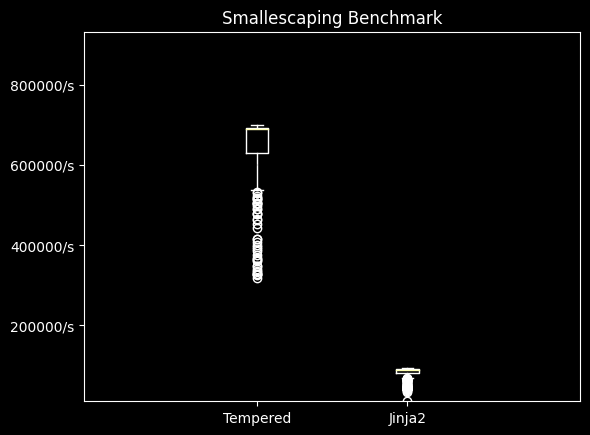

In [ ]:
benchmark_comparion(
    name="small_escaping",
    samples=100_000,
    jinja2_template="""
        {{ x }}
    """,
    tempered_template="""
        {{ x }}
    """,
)


## Large Escape

Jinja2 Renders/s:    4,303s
Tempered Renders/s:  4,303
Rendering Faster:    157.01%


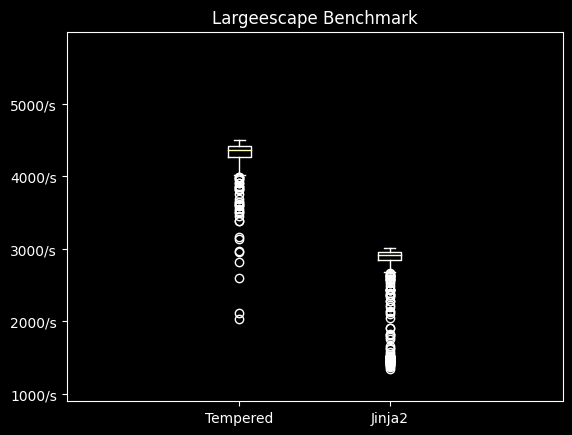

In [ ]:
jinja_template = """{{ x }}""" * 500
benchmark_comparion(
    name="large_escape",
    samples=10_000,
    jinja2_template=jinja_template,
    tempered_template=jinja_template,
)


## Big Data

In [ ]:
jinja_template = "a" * 1_000_000
benchmark_comparion(
    name="big_data",
    samples=10_000,
    jinja2_template=jinja_template,
    tempered_template=jinja_template,
    variables={},
)


# Interleave

Jinja2 Render Time:  0.0019s
Tempered Render Time: 0.0007s
Tempered Requests Per Second: 1,480
Rendering Faster:    280.00%


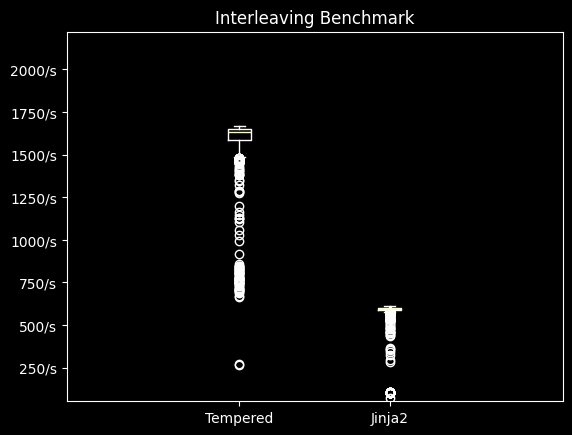

In [ ]:
jinja_template = "a {{ x }}" * 2000
benchmark_comparion(
    name="interleaving",
    samples=5000,
    jinja2_template=jinja_template,
    tempered_template=jinja_template,
)


## Layouts  

# Realworld

Jinja2 Render Time:  0.0003s
Tempered Render Time: 0.0001s
Tempered Requests Per Second: 11,335
Rendering Faster:    314.56%


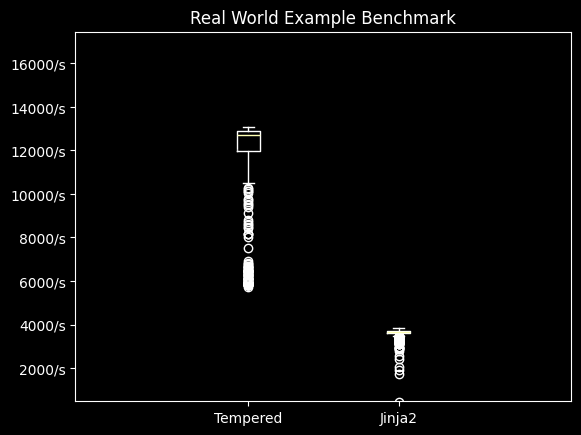

In [ ]:
from dataclasses import dataclass
import pickle
import gzip
import datetime
import base64


@dataclass
class User:
    id: int
    created_at: datetime.datetime
    username: str
    settings: str


@dataclass
class Profile(User):
    id: int
    created_at: datetime.datetime
    username: str
    settings: str
    videos: list[Video]
    comments: list[Comment]


@dataclass
class VideoFile:
    filename: str
    mimetype: str
    width: int
    height: int
    duration: float


@dataclass
class Image:
    filename: str
    mimetype: str
    width: int
    height: int


@dataclass
class Video:
    id: int
    created_at: datetime.datetime
    title: str
    description: str
    views: int

    thumbnail: Image
    file: VideoFile
    uploader: User
    comments: list[Comment]


@dataclass
class Comment:
    id: int
    author: User
    created_at: datetime.datetime
    editted_at: datetime.datetime | None
    text: str


user_b64 = "H4sIADCCfGUC/61ZW4wk11neXe/au+NL7AhjFJnkxCG210radU7VqarjSGjHnvXaXs/i7I7jKFxW5/KfrvJUV/VWVU+7DZZAyMESQyKUDlJeeIiQQOSFB4SQgoRIwlNAQkK8gAISIPFEJCReEELiO9Uzu+3BI43Y3dv07VTV1vf93+X0r579ZvnTp4Zf++dv3pzosr55c7n/wBtt48uKlt9YXvy15XvLZ/fPlG559f39DduS7snd1P1y/7zDw76c0PrDbyxf2njg3x564PH4ift++F/L95fX8e6so7bW4YOPvlp3fTubUN1v67rUFu921PdlPe6W+2d++b3l/v17paOmW/7i8tni1P65L4Vnty+kOHe1K+4vLqxO8pP3nT7/7Jurk5zry74KZ3jz2tbl6zubr19mn2evNOGkDzrqbFtO+7Kpl/t/dJ0sTl8tmKM9qpopK/uOdeVkWhFzrZ6zedPusmlLHU5d96wj3TX1iN0gzcraVjNHjNyYWKcXzJNuWUtjHJpRNyVb6qpajDau676gFocd16UvrcZxTFlV4WNVY3U1YlvU67JiddOXFsea2YIZrA0n7vsF0+OWKNynEf5veyXNu+VrF//z/lP7F/piNjE11i7D/Xl1osdrQJ0PuK3u9WVhhLFSZVIK6zxXnBIvfZ4KIklZ7ESaK5F6b7JUC6eM5pnOtOGZyHIeR3w0JzMFQBMA2y+mOORGGc72/Or1c/PS9cVy+9Lp/fsLKsdFv7z6xzOzf3agDq7twoDdy+tEKn5mf4vnmTRxrnGayEU2jdJECfxRIlLSWSMUd1zEZCOrMopc7DWuOJLSaq0j4qPJNFkWT+9fGIjy/PDs2e1T54qL239zBlSctXpA+sqlXj322Nu/+XVc0/nZtGq0ozZc19k3wcd1Sr1/h1JrvC0eLh4pPlY8GpbbZhKwCKycmeInbq9s18h45sFzP/qH1cpP7H96nYY36ma+YOxX2KXtpuyou1ZS3yyLJ/e7zbaZ1e6AVhgCVpQdc6UHZWYVqNeDnr7cI9Y3fSDNF2dlT6ypHDNUky97VjRzVlEPDnZYMWI7oA2W1MR01eCAd0jJJuRKPVoWn3ztcw+dO1V8qvj0bVAux7nxRgrKvNNkcu5jYQn8UFZHyoNGMo8p1/gM2JRrbbnzFgBGLnGRkwdcKZ4ungEWl04XFwMViueKz93BPUk4UWKiVCcUeeFSy9Moy3MHOljPhcARnXAmJiUcUS61cy4WPhFee2miA9yL6A7aBb9yqf3yBx88/8iDOJsokhNDWrxwBMlba0iefuzhP1WHSD65juQW5A9zumBXKj1pZm0A8dZVoikr9HS6YABpF5oAogW0XgqsacPdZ9Ni0UEGKjYvmslo46VmFuTGNM0ua2rMP3TVsa6ZBdWooQHN22SB5jbpGi/j76z1Gp/zTeMGCL/9+MePQBh5DJHMLAFLYKZSRV6kOhKpiJyJBMe851boLI9SKVMbxXlkjIoiblxmtDkBhN5JkkIkaZyRpkRnJuUKU8tTnuUikkKBGYlVXMoklYZHJiERp7mJY5nITB4D4a3P/+gfsy//wt1COF2D8NST51+gQwg/vg7hZjduWgrA/cErzZQO7zXbbjsI8Jj1pCHFExhaG4CbE+2O2Ga96Iswn5NZByUHVnoMs2QFprclB03vWeN7qkcbNzCdJaS/rHEEwqf7AhhOqfVNO9EBa+g3Xpk0AesRe4WqKZ64gHtLFc7Lgj/N2mBQ3RTzPuD98//86BG8odRxKkyqXMxjGQNpa73wqaPESZEk0kmvUx8eYrYcz6x0xCn3sUkpFdkJ8NY88pnDICa55jyKtfRwDpfl8JLMQgaclUZIayxxo7SPKZW4jpjiNIu04seN7F/eE7ybtQVfeOq+f/rdQ7yfWcf71f6Zjl0HWAG+GwgEc9x2YperbiDB771IVYkgwKbNdFbBzMk2dTMpLQy/196zyYFtTxpgOa30Athqa6HbPbNVsH/I72jjZaJqTbkN9WBOzWwxQI5jujK4EluQLkCqYJcH2M8D1Rjyh7ZBznscx5DVCE0rLoIkgQAtHdXsnJIMqi0ib2LuVALxlklugoxrzKbIDZdp5JQXRstIkndK5rmE32rJvRMnIEDKU+Ex6ybheSwSqUkoaZIogkdEnlKeCJ5myghuciFySxh1qUAI7XmsRXwMAcr/eOzRX3ry8bslQL224IUvXPhh+ZEDv02Tpl0ErBc3+hkQ7cp3WGchAkAuZIJhejsM3cozCbgcjPU8yDktAEQBLE05Hm38nLWzYbgbLCmapsJ7zazTcPFh0GswAl4L5gRRAbEC7wYAb7x79qjpwlhTIxPjhXIpMIQvZj5VmnISCTKRCVOdJkkmeEY2RjYSVhskJBPhlqcnANBKnatE+SxOjCCepJaiPOaZ4j4HfgkSYp5aF0mMriOfGpizz8kJzWUSJekxADb6ngA4WQfw8dMPvnYIIFsH8PqsrLuPSE8/eENDVsOIlS20ctLYkPwsQxnRkOwWj6shC0HGuz6E9cbOOoaB6qjymG8AVwX8YQM12w0uTvXbzQJSUGFYbcdCHvcaCrBgpg04bryCyKXbNkQySAFbmUJZ7zXVXjBxOHiLcTfa7jLXjNhbbRmGu29m4wIn1nsL1obRx1WNZyDgKo5tbZ45ygxLWoITCFgmFi5GfoeK6zhLMy00InOKjBZB/sEHZTMDzVfKJDq1qcoRq07AjDiTKvGp9hlHuOI+RGwNpqlY5Tgd6GuUzy3HFMdgWwjrCYpDBiZ6ntrsGGZMHvor/Prru2VGtbZAPfPwV791yIyn15nxou5R+thm8GKo8ybS74ygqu3Aj803Kj1Eq9BrGb2jh4oXIvW06brS4Ammnc3LrmDTQKURu9aADWG2W12PV8b7mf85qrsGdSnOtDUmgjBCfFPjUgcVzhFboYNppGUa29Q56C6HOKbkosQoynKvIu9PkpW9knGcSsUjUjzELO3kMKy5y6XR0FpO3DktJK7FS3iysrlMZa4MxdFxWfnWc3/4nbOfvXi34OyuLciT07/x34fgfOp1GhOUsPHsK1Q5DYiuUDtzDfsSRokGEf59FF9qJ6GhNIOWItL2B2WlwzQBlRptFwMd+vGIXSc3s6GZk55AkOG6iFluxN5oG7yBZwhKYxTew36NcA0xLsOOBAvXgnw3brG0L1pUpXZWr0r+IAto6myr7KAKXfBmBIChf+8NtRvYfyc9KtnIP3kOnYQ6x0LEEGcfJRY1NXYOqShTLncWRgkHTpVFPIsRnzyHwoegFskTYO8SzLiPkd3jBHTSyscJDBWGrrWKE0cmlWjFhjDt+MehnCWSozglFoObHjeYt7764x9/s791t9i/vY796Yf+9e8Psf/s1uXXdzavv3ktDObLJeAPNAgRGzoKHLYCgF1gwHuw4dXOCtJY2DXqgEaL+Z2X+Ny8DIbahzUQ8TCkYSsmfHw8WyAaDxAhJQH6YM/Q2AJQ70FlJw00eNi8OWATzD6Etek0pDQ06x45YMD11c37juAqfcyBWa4NbDEWeWKRrWQsHVdJapCqIJUZGpWEGiLnZoaGKoyhR8VC1DoBrio0pihGMUsVtxFKF6AlUAf46jQDddCVvMhiyROKgbLKEbPiWESGi9joY3DtPrgn/bdcW5CdO//nt2733/8706+HKPwWmugA529vh70rW+6VFbTWVwGZIRijvup2l5CadQuwihJYrtJ1GLtZMNTQewc8ob79Ah68GG3sFDT0oQq5bI7j4vWyDhuPHZLZa42BMljENgA6OdT2BqkOFKLVrtkA8ZWd00cgTnKXATsJpwTKXArMKeVJJCKhoKUizh2PUhu7JBUJpgp1R3FkWS8EZUrQCSBGxpZkfJIjiwurLA5nnLIcY4rzOK1jmSYGggHrxhHzNHEckdzC7bU2zh7nqd9+6qm/e+KTdwtxsbYg/cSZH7x/CPFPfWizalqGTLQVekuA93eu1s28GjY8i7BJYe9sakyasCkGPFabHTWmjULb6Zt5DSjCe1MNqixCQdoJO1jDPseCVUH9D9rtan+r1mi8FHZFhz3Z4bj9vAmzD/aAN+9MA6/Qkpq21wfyHH/tgaPyjH4iUonbHyPIRCZLeaS4y6wmyTOH247KknlEKGM1jNqGKhNFMs+g3ipXJ8AY8+kEGlQE+c9TT0qhAMWQB2OD2Cv4MZJ2hjKGaAWyQUq8sxm8OkuQnui4RC3uCcbjtQXyuUd+6zO3Mf6QPBMibAflRGkNGP/JTig6wx4UZtFS1w12idAalLjrkatpvAg74X3AfzoLobabjcfU9cGhbTOuy3cpbGYHAYb0z4NOG1qg9w66PAB6a1ba3bA7vtPMdetg91hjK11OEMYbi1yPRN3UQ0C+vX1ykJrDzgg8uivK6aEhBA5sv/cXRxjAIeKRRRuOlMkoV5HxjhuMMaoW4lOcxEmeaiQyDKAjCHmWoOWaKE6yKM7sSUqxTLQKFiy9RJeyIZVnOpKwYSUTB+hJICb7hEtrc8i9j6zMkMwRoGNNx5Xi6dfuiUH7tQWJePj7/3LIgCfWp/xKETT85WHXHgT49WuIXEMGZh3ccne1TQG8Q2y24csS6HY3CMNE18Fzmyo0oOALiHCYUA3DHna0PgRVkIUZ6hbTDomvHJi0+g4k+HMwAwgKzBnOP0z0V949aswZrFFaleK3TnyGggrsEoybVJklhGJnJdozfqCxIBoDckdoS5ZnEeX2RB05kwIUoDQSUGeEdg5/zyXHUbSzxHOhvDcGESDJkMGzxAF2hL3YRFJZfaxqf++eTDSt43n+7J99/xDP59YnenvBXoLUApSdIL4f0ZZnbw2bTitDDYMK7Z0wjSEdw0F1N2IvHuxZ+RCDw5cFYb/aNOGLg4kZBn7Yg8ashi/LFh/a0xyg79gYoQAZG5eBAS2bYedqO/v3I1nLaQ4x9jqPUqGRc2WEVuNyVFnhpM1yTRYp1yNieUQlJO3E5eg8eFdETpxkRDkyujTweK0lilQspMxTY3gMCxgaE88Nghgito+4SnXkKec+Qs+GhtssOW5E//a73zWbP/v/gpRWP0b/C1XgTGJ0HQAA"
user = pickle.loads(gzip.decompress(base64.b64decode(user_b64.encode())))

jinja_template = """
{% macro UserIcon(profile) -%}
    <a href="/user/{{profile.id}}">
        <img src="/static/Account.png" />
    </a>

    <style>
    a {
        width: 100%;
        height: 100%;
        padding: 1px;
        border-radius: 100px;
        border: 2px var(--text) solid;
        justify-content: flex-start;
        align-items: flex-start;
        gap: 10px;
        display: flex;
        box-sizing: border-box;
    }

    img {
        width: 100%;
        height: 100%;
        align-self: stretch;
        border-radius: 9999px;
    }
    </style>
{% endmacro -%}
{% macro Thumbnail(video) -%}
    <div class="thumbnail">
    <a href="/video/{{video.id}}" class="image">
        <img
        src="/media/{{video.thumbnail.filename}}"
        width="{{video.thumbnail.width}}"
        height="{{video.thumbnail.height}}"
        alt="{{video.title}}"
        />
    </a>
    <div class="metadata">
        <div class="account">
        {<UserIcon(profile=video.uploader)>}
        </div>
        <a href="/video/{{video.id}}" class="text">
        <span class="title">
            {{ video.title }}
        </span>
        <div class="info">
            <small>Milky</small>
            <small>{{ video.views }} views</small>
        </div>
        </a>
    </div>
    </div>

    <style>

    .thumbnail {
        width: 18rem;
        height: fit-content;
        padding: 0.5rem;

        display: flex;
        flex-direction: column;
        align-items: center;
        gap: 0.5rem;
    }
    a:link,
    a:visited {
        text-decoration: inherit;
        color: inherit;
    }

    .thumbnail {
        border-radius: var(--border-radius, 10px);
        background: var(--secondary);
    }

    .image {
        display: block;
        width: 100%;
        height: 10rem;
    }

    .image {
        border-radius: var(--border-radius, 10px);
        border: 2px solid var(--accent, #67A8A8);
    }

    .image>img {
        width: 100%;
        height: 100%;
        object-fit: cover;
        border-radius: var(--border-radius, 10px);
    }


    .metadata {
        display: grid;
        grid-template-columns: 2.5rem 1fr;
        gap: .5rem;
        width: 100%;
        height: 2.5rem;
    }

    .account {
        display: block;
        width: 2.5rem;
        height: 2.5rem;
    }

    .account>img {
        width: 100%;
        height: 100%;
    }

    .text {
        height: 100%;
        width: calc(100% - 1.5rem);

        display: flex;
        flex-direction: column;
        justify-content: flex-start;
        align-items: stretch;
    }

    .title {
        display: block;
        width: 100%;
        height: fit-content;
        max-height: 1.5rem;

        overflow: hidden;
        text-overflow: ellipsis;
        line-break: anywhere;
    }

    .info {
        display: flex;
        height: 15px;
        align-items: center;
        gap: 5px;
        align-self: stretch;
    }
    </style>
{% endmacro -%}

{% macro Comment(comment) -%}
    <div class="comment">
        <div class="icon">
            {<UserIcon(profile=comment.author)>}
        </div>
        <div
            style="flex-direction: column; justify-content: flex-start; align-items: flex-start; gap: 2px; display: inline-flex">
            <div style="width: 100%; justify-content: flex-start; align-items: center; gap: 5px; display: inline-flex">
                <span>
                    {{ comment.author.username }}
                </span>
                <small>
                    {{ comment.created_at.strftime("%-d/%-m/%y %H:%M").title() }}
                </small>

                {% if comment.editted_at is not None %}
                <small>
                    Editted
                </small>
                {% endif %}
            </div>
            <div style="width: 90%; height: 2px; background: #BFBFBF">

            </div>
            <span>
                {{ comment.text }}
            </span>
        </div>
    </div>

    <style>
        .comment {
            width: 100%;
            height: fit-content;
            padding: 5px;
            box-sizing: border-box;

            background: var(--secondary);
            border-radius: var(--border-radius);

            display: grid;
            grid-template-columns: 2.5rem 1fr;
            gap: .5rem;
        }

        .icon {
            height: 2.5rem;
            width: 2.5rem;
        }

        .text {

        }
    </style>
{% endmacro -%}

<div style="width: 100%; height: 100%; position: relative">
    <div id="header">
        <div
            style="width: 160px; height: 160px; align-self: stretch; padding: 1px; border-radius: 100px; border: 2px var(--text) solid; justify-content: flex-start; align-items: flex-start; gap: 10px; display: inline-flex">
            <img style="flex: 1 1 0; align-self: stretch; border-radius: 9999px"
                src="https://via.placeholder.com/158x158" />
        </div>
        <div id="info">
            <h3>
                {{user.username}}
            </h3>
        </div>
    </div>
    <div id="content">
        <div>
            <h3 style="width: 100%; text-align: center;">Comments</h3>
            <div id="comments">
                {% for comment in user.comments %}
                    {{ Comment(comment) }}
                {% endfor %}
            </div>
        </div>
        <div>
            <h3 style="width: 100%; text-align: center;">Videos</h3>
            <div id="videos">
                {% for video in user.videos %}
                    {{ Thumbnail(video) }}
                {% endfor %}
            </div>
        </div>
    </div>
</div>

<style>
    #header {
        height: 15rem;
        width: 100%;
        padding: 1rem;
        box-sizing: border-box;

        display: flex;
        justify-content: center;
        gap: 20px;

        background: #1C1C1C;
    }

    #info {
        width: 100%;
        align-self: stretch;
        flex-direction: column;
        justify-content: flex-start;
        align-items: flex-start;
        gap: 10px;
        display: inline-flex;
    }

    #content {
        height: calc(100vh - var(--nav-height) - 15rem);
        display: grid;
        grid-template-columns: 20rem 1fr;
    }

    #videos {
        padding: 1rem;
        display: inline-flex;
        flex-flow: row wrap;
        justify-content: center;
        gap: 1rem;

        overflow-y: auto;
    }

    #comments {
        overflow-y: auto;
        flex-direction: column;
        justify-content: flex-start;
        align-items: center;
        gap: 20px;
        display: inline-flex;
    }
</style>
"""

tempered_template = """
{% param user %}
<div style="width: 100%; height: 100%; position: relative">
    <div id="header">
        <div
            style="width: 160px; height: 160px; align-self: stretch; padding: 1px; border-radius: 100px; border: 2px var(--text) solid; justify-content: flex-start; align-items: flex-start; gap: 10px; display: inline-flex">
            <img style="flex: 1 1 0; align-self: stretch; border-radius: 9999px"
                src="https://via.placeholder.com/158x158" />
        </div>
        <div id="info">
            <h3>
                {{user.username}}
            </h3>
        </div>
    </div>
    <div id="content">
        <div>
            <h3 style="width: 100%; text-align: center;">Comments</h3>
            <div id="comments">
                {% for comment in user.comments %}
                    {<Comment(comment=comment)>}
                {% endfor %}
            </div>
        </div>
        <div>
            <h3 style="width: 100%; text-align: center;">Videos</h3>
            <div id="videos">
                {% for video in user.videos %}
                    {<Thumbnail(video=video)>}
                {% endfor %}
            </div>
        </div>
    </div>
</div>

<style>
    #header {
        height: 15rem;
        width: 100%;
        padding: 1rem;
        box-sizing: border-box;

        display: flex;
        justify-content: center;
        gap: 20px;

        background: #1C1C1C;
    }

    #info {
        width: 100%;
        align-self: stretch;
        flex-direction: column;
        justify-content: flex-start;
        align-items: flex-start;
        gap: 10px;
        display: inline-flex;
    }

    #content {
        height: calc(100vh - var(--nav-height) - 15rem);
        display: grid;
        grid-template-columns: 20rem 1fr;
    }

    #videos {
        padding: 1rem;
        display: inline-flex;
        flex-flow: row wrap;
        justify-content: center;
        gap: 1rem;

        overflow-y: auto;
    }

    #comments {
        overflow-y: auto;
        flex-direction: column;
        justify-content: flex-start;
        align-items: center;
        gap: 20px;
        display: inline-flex;
    }
</style>
"""
comment_template = """
{% param comment %}

<div class="comment">
    <div class="icon">
        {<UserIcon(profile=comment.author)>}
    </div>
    <div
        style="flex-direction: column; justify-content: flex-start; align-items: flex-start; gap: 2px; display: inline-flex">
        <div style="width: 100%; justify-content: flex-start; align-items: center; gap: 5px; display: inline-flex">
            <span>
                {{ comment.author.username }}
            </span>
            <small>
                {{ comment.created_at.strftime("%-d/%-m/%y %H:%M").title() }}
            </small>

            {% if comment.editted_at is not None %}
            <small>
                Editted
            </small>
            {% endif %}
        </div>
        <div style="width: 90%; height: 2px; background: #BFBFBF">

        </div>
        <span>
            {{ comment.text }}
        </span>
    </div>
</div>

<style>
    .comment {
        width: 100%;
        height: fit-content;
        padding: 5px;
        box-sizing: border-box;

        background: var(--secondary);
        border-radius: var(--border-radius);

        display: grid;
        grid-template-columns: 2.5rem 1fr;
        gap: .5rem;
    }

    .icon {
        height: 2.5rem;
        width: 2.5rem;
    }

    .text {

    }
</style>
"""
thumbnail_template = """
{% param video %}

<div class="thumbnail">
<a href="/video/{{video.id}}" class="image">
    <img
    src="/media/{{video.thumbnail.filename}}"
    width="{{video.thumbnail.width}}"
    height="{{video.thumbnail.height}}"
    alt="{{video.title}}"
    />
</a>
<div class="metadata">
    <div class="account">
    {<UserIcon(profile=video.uploader)>}
    </div>
    <a href="/video/{{video.id}}" class="text">
    <span class="title">
        {{ video.title }}
    </span>
    <div class="info">
        <small>Milky</small>
        <small>{{ video.views }} views</small>
    </div>
    </a>
</div>
</div>

<style>

.thumbnail {
    width: 18rem;
    height: fit-content;
    padding: 0.5rem;

    display: flex;
    flex-direction: column;
    align-items: center;
    gap: 0.5rem;
}
a:link,
a:visited {
    text-decoration: inherit;
    color: inherit;
}

.thumbnail {
    border-radius: var(--border-radius, 10px);
    background: var(--secondary);
}

.image {
    display: block;
    width: 100%;
    height: 10rem;
}

.image {
    border-radius: var(--border-radius, 10px);
    border: 2px solid var(--accent, #67A8A8);
}

.image>img {
    width: 100%;
    height: 100%;
    object-fit: cover;
    border-radius: var(--border-radius, 10px);
}


.metadata {
    display: grid;
    grid-template-columns: 2.5rem 1fr;
    gap: .5rem;
    width: 100%;
    height: 2.5rem;
}

.account {
    display: block;
    width: 2.5rem;
    height: 2.5rem;
}

.account>img {
    width: 100%;
    height: 100%;
}

.text {
    height: 100%;
    width: calc(100% - 1.5rem);

    display: flex;
    flex-direction: column;
    justify-content: flex-start;
    align-items: stretch;
}

.title {
    display: block;
    width: 100%;
    height: fit-content;
    max-height: 1.5rem;

    overflow: hidden;
    text-overflow: ellipsis;
    line-break: anywhere;
}

.info {
    display: flex;
    height: 15px;
    align-items: center;
    gap: 5px;
    align-self: stretch;
}
</style>
"""
usericon_template = """
{% param profile %}

<a href="/user/{{profile.id}}">
  <img src="/static/Account.png" />
</a>

<style>
  a {
    width: 100%;
    height: 100%;
    padding: 1px;
    border-radius: 100px;
    border: 2px var(--text) solid;
    justify-content: flex-start;
    align-items: flex-start;
    gap: 10px;
    display: flex;
    box-sizing: border-box;
  }

  img {
    width: 100%;
    height: 100%;
    align-self: stretch;
    border-radius: 9999px;
  }
</style>
"""

benchmark_comparion(
    name="Real World Example",
    samples=25_000,
    jinja2_template=jinja_template,
    tempered_template=tempered_template,
    additional_tempered_templates=[
        ("Comment", comment_template),
        ("Thumbnail", thumbnail_template),
        ("UserIcon", usericon_template),
    ],
    variables={"user": user},
)

In [ ]:
finalise()